In [1]:
# Constantes
def OFFICE_ID(i):
    return "office_" + str(i)

def CLIENT_ID(i):
    return "client_" + str(i)

LIMITE_POBLACION_INICIAL = 5000
URL = "./data/fl_3_1"

In [2]:
# Funciones matemáticas
import math

def distance(p1, p2):
    return math.sqrt(math.pow((p1.x - p2.x), 2) + math.pow((p1.y - p2.y), 2))

In [3]:
# Definición de clases
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Client:
    def __init__(self, clientId, point, cost):
        self.point = point
        self.cost = cost
        self.clientId = clientId
        
class Office:
    def __init__(self, officeId, point, cost, storage):
        self.point = point
        self.cost = cost
        self.storage = storage
        self.officeId = officeId
        self.avaibleStorage = storage
    
    def resetStorage(self, storage):
        self.avaibleStorage = storage
    
    def setStorage(self, clientCost):
        self.avaibleStorage = self.avaibleStorage - clientCost
        
class Individual:
    def __init__(self, officesOfClients, idn):
        self.officesOfClients = officesOfClients
        self.idn = idn
        
    def __eq__(self, other):
        """Override the default Equals behavior"""
        if isinstance(other, self.__class__):
            return self.__dict__ == other.__dict__
        return NotImplemented
    
    def removeGenBySede(self, idn):
        self.officesOfClients =  list(filter(lambda ind: ind[0].officeId != idn, self.officesOfClients))
    
    def addGen(self, gen):
        self.officesOfClients.append(gen)
    
    def addSedeOfClients(self, newAdn):
        self.officesOfClients =  self.officesOfClients + newAdn
        
    def fitness(self):
        size = len(self.officesOfClients)
        cost = 0
        for i in range(0, size):
            sede, cliente = self.officesOfClients[i]
            dist = distance(sede.point, cliente.point)
            cost = cost + (dist * sede.cost)
        return cost
    
    @staticmethod
    def validRestrictions(officesOfClients, offices):
        for office in offices:
            clientsOfOffice = list(filter(lambda officeClient : officeClient[0].officeId == office.officeId, officesOfClients))
            if clientsOfOffice:
                costoTotal = 0
                sede, _ = clientsOfOffice[0]
                almacenamientoSede = sede.storage
                for _ , client in clientsOfOffice:
                    costoTotal = costoTotal + client.cost
                if costoTotal > almacenamientoSede:
                    return False
        return True
    

class Population:
    def __init__(self, individuals):
        self.individuals = individuals
        
    def getIndividualByIndex(self, index):
        return self.individuals[index]
    
    def addIndividual(self, inds):
        self.individuals = self.individuals + inds

In [4]:
#Utilidades
def resetAvaibleStorage(sedes):
    for sede in sedes:
        sede.resetStorage(sede.storage)

def existIndividual(listInd, ind):
    for i in listInd:
        if (i.officesOfClients == ind.officesOfClients):
            return True
            break
    return False

def getIndexById(sedes, idn):
    return [s for s in sedes if s.officeId == idn][0]


In [5]:
# procesamiento de datos
def procesarDatos(url):
    sedes = []
    clientes = []
    sede_id = 0
    cliente_id = 0
    with open(url) as f:
        i = 1
        for line in f:
            l = line.split()
            if i == 1:
                cant_sedes = int(l[0])
                cant_clientes = int(l[1])
            else:
                if (cant_sedes > 0):
                    sedes.append(Office(str(sede_id), Point(float(l[2]), float(l[3])), float(l[0]), float(l[1]) ))
                    sede_id = sede_id + 1
                else:
                    clientes.append(Client(str(cliente_id), Point(float(l[1]), float(l[2])), float(l[0])))
                    cliente_id = cliente_id + 1
                cant_sedes = cant_sedes - 1    
            i = i + 1
    return (sedes, clientes)

In [6]:
from random import randint


In [7]:
import random
import math

def crearPoblacion(numIndividuos, sedes, clientes):
    numSedes = len(sedes)
    numClientes = len(clientes)
    salir = False
                    
    poblacion = []
    j = 0
    k = j
    while j < numIndividuos and not salir:
        individuo = []
        for i in range(0, numClientes):        
            cliente = clientes[i]
            sedesDisponibles = list(filter(lambda sede: sede.avaibleStorage >= cliente.cost, sedes))
            if len(sedesDisponibles) == 0:
                resetAvaibleStorage(sedes)
                break
            index =  random.randint(0, (len(sedesDisponibles) - 1))
            sede = sedesDisponibles[index]
            sede.setStorage(cliente.cost)
            individuo.append((sede, cliente))
        ind = Individual(individuo, j)
        k = k +1
        if(k > numIndividuos * 10):
                salir = True
        if not existIndividual(poblacion, ind):    
            poblacion.append(ind)
            j = j + 1
        resetAvaibleStorage(sedes)
    return Population(poblacion)

def seleccionPorElitismo(poblacion, sample):
    poblacionTam = len(poblacion.individuals)
    selectInds = int(poblacionTam * sample)
    fit=[]
    for ind in poblacion.individuals:
        fit.append((ind.fitness(), ind))
    return [x[1] for x in sorted(fit, key=lambda student: student[0])[:selectInds]]
    
def seleccionPorTorneo(poblacion, sample, numeroDeParticipantes):
    poblacionTam = len(poblacion.individuals)
    if numeroDeParticipantes > poblacionTam:
        raise Exception('El número de participantes debe ser menor a la población')
    selectInds = int(poblacionTam * sample)
    inds = []
    p = poblacion.individuals
    i = 0
    while i < selectInds:
        if(len(p) < numeroDeParticipantes):
            numeroDeParticipantes = len(p)
        indsTorneo = random.sample(p, numeroDeParticipantes)
        fit = []
        for ind in indsTorneo:
            fit.append((ind.fitness(), ind))
        participantes = [x[1] for x in sorted(fit, key=lambda student: student[0])]
        ganador = participantes[0]
        inds.append(ganador)
        p = [a for a in p if a != ganador]
        i = i + 1 
    return inds

def mutacion(poblacion, prob, sedes):
    for ind in poblacion.individuals:
        rnd = random.random()     
        if rnd <=  prob:
            x = ind.officesOfClients
            numeroDeGenes = len(x)
            index = random.randint(0, numeroDeGenes-1)
            sedeMutante, _ = x[index]
            sedemMutanteId = sedeMutante.officeId
            clientesMutantes = [cli[1] for cli in list(filter(lambda z: z[0].officeId == sedemMutanteId, x))]
            clientesCost = sum(c.cost for c in clientesMutantes)
            sedeStorage = sedeMutante.storage
            for sede in sedes:
                sedeSustitutaId = sede.officeId
                if sedeSustitutaId != sedemMutanteId:
                    clientesSustitutos = [cli[1] for cli in list(filter(lambda z: \
                                                                      z[0].officeId == sedeSustitutaId, x))]
                    clientesSustitutosCost = sum(c.cost for c in clientesSustitutos)
                    sedeSustitutosStorageStorage = sede.storage
                    if clientesCost <= sedeSustitutosStorageStorage and clientesSustitutosCost <= sedeStorage:
                        ind.removeGenBySede(sedemMutanteId)
                        ind.removeGenBySede(sedeSustitutaId)
                        l1 = [(sede, c) for c in clientesMutantes]
                        l2 = [(sedeMutante, c) for c in clientesSustitutos]
                        ind.addSedeOfClients(l1 + l2)
                        break
    return poblacion  

def cruce(poblacion, clientes, sedes, hijosSample):
    # declarar variables iniciales
    numeroDeHijos = math.ceil(hijosSample * len(poblacion.individuals))
    poblacionReproductora = seleccionPorElitismo(poblacion, 1)
    machos = poblacionReproductora[::2]
    hembras = poblacionReproductora[1::2]
    i = 0
    m = 0
    h = 0
    hijos = []
    # ciclo principal
    while(i < numeroDeHijos):
        # si no ha mas machos terminar ciclo principal
        if len(machos) <= m: 
            break
        huerfanos = []
        padre = machos[m].officesOfClients
        madre = hembras[h].officesOfClients
        hijo = []
        genes = set()
        # ciclo para cada sese
        for sede in sedes:
            # traer clientes de las sede en el padre y la madre
            sedeSustitutaId = sede.officeId 
            clienteSedeMacho = clientesSustitutos = [s[1] for s in list(filter(lambda z: \
                                                                      z[0].officeId == sedeSustitutaId, padre))]
            clienteSedeHembra= clientesSustitutos = [s[1] for s in list(filter(lambda z: \
                                                                      z[0].officeId == sedeSustitutaId, madre))]
            #total de clientes en padre y madre
            clientesCruce = list(set(clienteSedeMacho + clienteSedeHembra) - genes)
            tamClientesCruce = len(clientesCruce)
            salir = False
            # ciclo para asignar los clientes de padre y madre en el hijo
            while not salir:
                # si aun hay clientes por asignar continuar
                if len(clientesCruce) != 0:
                    # hallar los clientes cuyo costo es menor al almacenamiento de la sede
                    availableClients= [c for c in list(filter(lambda z: \
                                                                          z.cost <= sede.avaibleStorage, clientesCruce))]
                    # si existen clientes que pueden ser asignados a la sede continuar
                    if len(availableClients) != 0:
                        # elegir un cliente aleatorio 
                        index =  random.randint(0, (len(availableClients) - 1))
                        cliente = availableClients[index]
                        # hacer asignacion de cliente-sede en el hijo
                        genes.add(cliente)
                        hijo.append((sede, cliente))
                        # eliminar el cliente asignado de la lista de clientes por asignar
                        clientesCruce = list(filter(lambda z: z.clientId != cliente.clientId, clientesCruce))
                        #actualizar el almacenamiento disponible de la sede
                        sede.setStorage(cliente.cost)
                    else:
                        # si no existen clentes que pueden ser asignados a la sede gurdarlos en huerfanos
                        huerfanos.append(clientesCruce)
                        # salir del cico de asignacion
                        salir = True
                else: 
                    # si se terminaron de asignar todos los clientes salir del ciclo de asignación
                    salir = True
        # aplastar lista de huerfanos
        huerfanos = [item for sublist in huerfanos for item in sublist]
        huerfanos = list(set(huerfanos) - genes)
        # asignar clientes huerfanos a sede si existen
        for huerfano in huerfanos:
            # ciclo para buscar sede para cliente huerfano
            for sede in sedes:
                # si la sede puede asignar al cliente continuar
                if huerfano.cost <= sede.avaibleStorage:
                    # asignar cliente huerfano a sede
                    hijo.append((sede, huerfano))
                    # actualizar almacenamiento de la sede
                    sede.setStorage(huerfano.cost)
                    break
        
        # restaurar almacenamiento de las sedes            
        resetAvaibleStorage(sedes)
        # escoger otra madre en la siguiente iteración
        h = h + 1
        # si no existen mas madres
        if h == len(hembras) - 1:
            # cambiar padre en la siguiente iteración y reiniciar madres
            m = m + 1
            h = 0
        # crear individuo
        ind = Individual(hijo, i)
        # si el hijo  no existe en la poblacion
        if (not existIndividual(poblacion.individuals, ind)):
            # agregar hijo a la poblacion
            hijos.append(ind)
            i = i + 1
    return hijos

In [8]:
# genetic algorithm

def geneticAlgorithm(path, generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample):
    sedes, clientes = procesarDatos(path)
    #print("init")
    seleccionTorneo = 1 - seleccionElitismo
    participantesTorneo = int(participantesTorneoSample * tamPoblacion)
    poblacion = crearPoblacion(tamPoblacion, sedes, clientes)
    tamPoblacion = len(poblacion.individuals)
    tamTorneo = seleccionTorneo * tamPoblacion
    tamElitismo = seleccionElitismo * tamPoblacion
    best = []
    #print("repeat_init: " + str(repeatInd(poblacion.individuals)))
    for i in range(generaciones):
        #print("i: " + str(i))
        hijos = Population(cruce(poblacion, clientes, sedes, hijosSample))
        #print("repeat_cruce: " + str(repeatInd(hijos.individuals)))
        hijos = mutacion(hijos, mutacionProb, sedes)
        poblacion.addIndividual(hijos.individuals)
        #print(str(len(poblacion.individuals)))
        #print("repeat_mutacion: " + str(repeatInd(poblacion.individuals)))
        tamPoblacion = len(poblacion.individuals)
        sE = tamElitismo / tamPoblacion 
        p1 = seleccionPorElitismo(poblacion, sE)
        #print("elitismoS")
        pParaTorneo = Population([a for a in poblacion.individuals if a not in p1])
        sT = tamTorneo / len(pParaTorneo.individuals)
        p2 = seleccionPorTorneo(pParaTorneo, sT, participantesTorneo)
        #print("torneoS")
        poblacion = Population(p1 + p2)
        mejorIndividuo = seleccionPorElitismo(poblacion, 1/len(poblacion.individuals))[0]
        #print("repeat_select: " + str(repeatInd(poblacion.individuals)))
        best.append((mejorIndividuo, mejorIndividuo.fitness()))
    return best
    
    

In [9]:
import matplotlib.pyplot as plt

def saveSolucion(solucion, path):
    strResp = str(solucion[1]) + "\n"
    ind = solucion[0].officesOfClients
    for x in ind:
        strResp = strResp + x[0].officeId + " "
    
    file = open(path, 'w')
    file.write(strResp)
    file.close()

def execGeneticAlgorithm(pathIn, pathOut, generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample):
    x = geneticAlgorithm(pathIn, generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample)
    saveSolucion(x[-1], pathOut)
    return x

In [36]:
"""
* método de algorimo genetico para el problema de asiganción
* Parametros:
*   - pathIn: indica la dirección de donde se cargaran los datos.
*   - pathOut: indica la dirección donde se guardaran los resultados
*   - tamPoblacion: indica el número de individuos que tendra la población.
*   - hijosSample: indica el porcentaje de hijos que  se crearan en base a la población inicial.
*   - mutacionProb: probabilidad de que un hijo mute.
*   - seleccionElitismo: Indica el porcentaje de individuos que seran seleccionados con elitismo 
*     (el procentaje de individuos seleccionados por torneo sera de 1 - seleccionElitismo)
*   - participantesTorneoSample: porcentaje de individuos que participaran en un torneo en la selección por torneo
"""

pathIn =  "./data/fl_16_1"
pathOut = "./solucion.txt"
generaciones = 100
tamPoblacion = 10
hijosSample = 0.8
mutacionProb = 1
seleccionElitismo = 0.1
participantesTorneoSample = 0.2

x = execGeneticAlgorithm(pathIn, pathOut, generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample)
x

[(<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470>, 31578760004.400105),
 (<__main__.Individual at 0x7f1797a81470

In [10]:
def geneticAlgorithmExperiments(path, poblacion, generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample):
    sedes, clientes = procesarDatos(path)
    #print("init")
    seleccionTorneo = 1 - seleccionElitismo
    participantesTorneo = int(participantesTorneoSample * tamPoblacion)
    tamPoblacion = len(poblacion.individuals)
    tamTorneo = seleccionTorneo * tamPoblacion
    tamElitismo = seleccionElitismo * tamPoblacion
    best = []
    #print("repeat_init: " + str(repeatInd(poblacion.individuals)))
    for i in range(generaciones):
        #print("i: " + str(i))
        hijos = Population(cruce(poblacion, clientes, sedes, hijosSample))
        #print("repeat_cruce: " + str(repeatInd(hijos.individuals)))
        hijos = mutacion(hijos, mutacionProb, sedes)
        poblacion.addIndividual(hijos.individuals)
        #print(str(len(poblacion.individuals)))
        #print("repeat_mutacion: " + str(repeatInd(poblacion.individuals)))
        tamPoblacion = len(poblacion.individuals)
        sE = tamElitismo / tamPoblacion 
        p1 = seleccionPorElitismo(poblacion, sE)
        #print("elitismoS")
        pParaTorneo = Population([a for a in poblacion.individuals if a not in p1])
        sT = tamTorneo / len(pParaTorneo.individuals)
        p2 = seleccionPorTorneo(pParaTorneo, sT, participantesTorneo)
        #print("torneoS")
        poblacion = Population(p1 + p2)
        mejorIndividuo = seleccionPorElitismo(poblacion, 1/len(poblacion.individuals))[0]
        #print("repeat_select: " + str(repeatInd(poblacion.individuals)))
        best.append((mejorIndividuo, mejorIndividuo.fitness()))
    return best

In [11]:
def graficar(mean, std, iteraciones):
    x = [x + 1 for x in range(iteraciones + 1)]
    plt.figure(figsize=(15, 8))
    plt.errorbar(x, mean, yerr=std, fmt='-o', ecolor='r')
    plt.show()

def experimentos(pathIn, numExperimentos,generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample):
    sedes, clientes = procesarDatos(pathIn)
    poblacion = crearPoblacion(tamPoblacion, sedes, clientes)

    c = [str(x) for x in range(generaciones + 1)]
    df = pd.DataFrame(columns = c)
    mejorIndividuo = seleccionPorElitismo(poblacion, 1/len(poblacion.individuals))[0]
    mejorIndividuoInicial = seleccionPorElitismo(poblacion, 1/len(poblacion.individuals))[0].fitness()


    for i in range(numExperimentos):
        print("experimento: " + str(i + 1))
        p = Population(poblacion.individuals[:])
        x = geneticAlgorithmExperiments(pathIn, p, generaciones, \
                                        tamPoblacion, hijosSample, mutacionProb, \
                                        seleccionElitismo, participantesTorneoSample)
        df.loc[len(df)] = [mejorIndividuoInicial] + [a[1] for a in x]


    mean = df[c].mean().tolist()
    std = df[c].std().tolist()
    graficar(mean, std, generaciones)


experimento: 1
experimento: 2
experimento: 3
experimento: 4
experimento: 5
experimento: 6
experimento: 7
experimento: 8
experimento: 9
experimento: 10


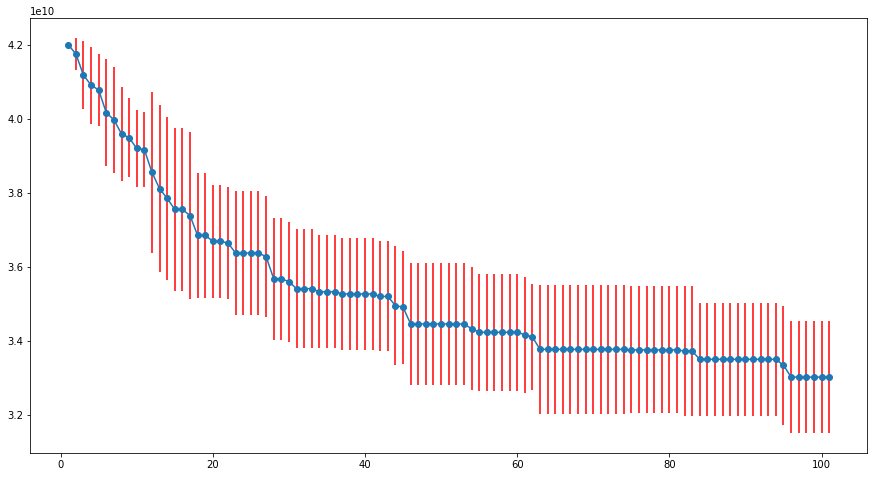

In [12]:
# Experimentos

import pandas as pd
import numpy as np

pathIn =  "./data/fl_16_1"
generaciones = 100
tamPoblacion = 10
hijosSample = 2
mutacionProb = 1
seleccionElitismo = 0.1
participantesTorneoSample = 0.2
numExperimentos = 10

experimentos(pathIn, numExperimentos,generaciones, tamPoblacion, hijosSample, mutacionProb, seleccionElitismo, participantesTorneoSample)